# Deep Reinforcement Learning
## PPO X GAE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import moviepy.editor as mpy
import skimage.transform
from IPython.display import Image, display

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls

In [2]:
!nvidia-smi

Fri Dec 24 12:27:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   43C    P8    13W / 250W |     21MiB / 11176MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   

In [3]:
gpus = tf.config.list_physical_devices("GPU") 
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.set_visible_devices(gpus[1], 'GPU')

        tf.config.experimental.set_memory_growth(gpus[1], True)
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


In [3]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line make pop-out window not appear
from ple.games.flappybird import FlappyBird
from ple import PLE

game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

test_game = FlappyBird()
test_env = PLE(test_game, fps=30, display_screen=False)
test_env.reset_game()

couldn't import doomish
Couldn't import doom


In [4]:
hparas = {
    'image_size': 84,
    'num_stack': 4,
    'action_dim': len(env.getActionSet()),
    'hidden_size': 256,
    'lr': 0.0001,
    'gamma': 0.99,
    'lambda': 0.95,
    'clip_val': 0.2,
    'ppo_epochs': 8,
    'test_epochs': 1,
    'num_steps': 512,
    'mini_batch_size': 64,
    'target_reward': 200,
    'max_episode': 30000,
}

In [5]:
# Please do not modify this method
def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    
    return clip

In [6]:
def preprocess_screen(screen):
    screen = skimage.transform.rotate(screen, -90, resize=True)
    screen = screen[:400, :]
    screen = skimage.transform.resize(screen, [hparas['image_size'], hparas['image_size'], 1])
    return screen.astype(np.float32)

def frames_to_state(input_frames):
    if(len(input_frames) == 1):
        state = np.concatenate(input_frames*4, axis=-1)
    elif(len(input_frames) == 2):
        state = np.concatenate(input_frames[0:1]*2 + input_frames[1:]*2, axis=-1)
    elif(len(input_frames) == 3):
        state = np.concatenate(input_frames + input_frames[2:], axis=-1)
    else:
        state = np.concatenate(input_frames[-4:], axis=-1)

    return state

In [7]:
class ActorCriticNetwork(tf.keras.Model):
    def __init__(self, hparas):
        super().__init__()

        self.feature_extractor = tf.keras.Sequential([
          # Convolutional Layers
          tf.keras.layers.Conv2D(filters=32, kernel_size=8, strides=4),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1),
          tf.keras.layers.ReLU(),
          # Embedding Layers
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(hparas['hidden_size']),
          tf.keras.layers.ReLU(),
        ])

        # Actor Network
        self.actor = tf.keras.layers.Dense(hparas['action_dim'], activation='softmax')
        # Critic Network
        self.critic = tf.keras.layers.Dense(1, activation = None)

    def call(self, input):
        x = self.feature_extractor(input)
        action_logits = self.actor(x)
        value = self.critic(x)
        return action_logits, value

In [8]:
class Agent():
    def __init__(self, hparas):
        self.gamma = hparas['gamma']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=hparas['lr'])
        self.actor_critic = ActorCriticNetwork(hparas)
        self.clip_pram = hparas['clip_val']
    
    def ppo_iter(self, mini_batch_size, states, actions, log_probs, returns, advantage):
        batch_size = states.shape[0]
        for _ in range(batch_size // mini_batch_size):
            rand_ids = tf.convert_to_tensor(np.random.randint(0, batch_size, mini_batch_size), dtype=tf.int32)
            yield tf.gather(states, rand_ids), tf.gather(actions, rand_ids), tf.gather(log_probs, rand_ids), \
             tf.gather(returns, rand_ids), tf.gather(advantage, rand_ids)
    
    def ppo_update(self, ppo_epochs, mini_batch_size, states, actions, log_probs, discount_rewards, advantages):       
        total_actor_loss = 0
        total_critic_loss = 0
        for _ in range(ppo_epochs):
            for state, action, old_log_probs, reward, advantage in self.ppo_iter(mini_batch_size, states, actions, log_probs, discount_rewards, advantages):
                reward = tf.expand_dims(reward, axis=-1)

                with tf.GradientTape() as tape:
                    prob, value = self.actor_critic(state, training=True)
                    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
                    entropy = tf.math.reduce_mean(dist.entropy())
                    new_log_probs = dist.log_prob(action)

                    # PPO ratio
                    ratio = tf.math.exp(new_log_probs - old_log_probs)
                    surr1 = ratio * advantage
                    surr2 = tf.clip_by_value(ratio, 1.0 - self.clip_pram, 1.0 + self.clip_pram) * advantage

                    actor_loss = tf.math.negative(tf.math.reduce_mean(tf.math.minimum(surr1, surr2))) - 0.1 * entropy
                    critic_loss = 0.5 * tf.math.reduce_mean(kls.mean_squared_error(reward, value))

                    total_loss = actor_loss + critic_loss
            
                # single optimizer
                grads = tape.gradient(total_loss, self.actor_critic.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.actor_critic.trainable_variables))
      
                total_actor_loss += actor_loss
                total_critic_loss += critic_loss
        return total_actor_loss, total_critic_loss

In [9]:
# https://arxiv.org/pdf/1506.02438.pdf
# Equation 16
def compute_gae(rewards, masks, values, gamma, LAMBDA):
    gae = 0
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * masks[i] - values[i]
        gae = delta + gamma * LAMBDA * masks[i] * gae
        returns.append(gae + values[i])

    returns.reverse()
    return returns

## Testing Environment

In [10]:
def test_reward(test_env, agent):
    total_reward = 0
    # Reset the environment
    test_env.reset_game()
    input_frames = [preprocess_screen(test_env.getScreenGrayscale())]

    while not test_env.game_over():

        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        action = np.argmax(prob[0].numpy())
        reward = test_env.act(test_env.getActionSet()[action])
        total_reward += reward

        input_frames.append(preprocess_screen(test_env.getScreenGrayscale()))

    return total_reward

## Training

In [11]:
agent = Agent(hparas)
max_episode = hparas['max_episode']
test_per_n_episode = 10
force_save_per_n_episode = 1000
early_stop_reward = 10

start_s = 0
best_reward = -5.0

checkpoint = tf.train.Checkpoint(
    actor_critic = agent.actor_critic,
    optimizer = agent.optimizer,
)

# Load from old checkpoint
# checkpoint.restore('ckpt_dir/ckpt-?')

In [12]:
# Load from old checkpoint
checkpoint.restore('./save/checkpoints/ckpt-22')

In [13]:
agent.actor_critic = tf.keras.models.load_model('./save/Actor/model_actor_280_36.0')
agent.actor_critic.compile()

In [15]:
ep_reward = []
total_avgr = []
early_stop = False
avg_rewards_list = []

env.reset_game()

for s in range(0, max_episode):
    if early_stop == True:
        break

    rewards = []
    states = []
    actions = []
    log_probs = []
    masks = []
    values = []

    display_frames = [env.getScreenRGB()]
    input_frames = [preprocess_screen(env.getScreenGrayscale())]

    for step in range(hparas['num_steps']):

        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        dist = tfp.distributions.Categorical(probs=prob[0], dtype=tf.float32)
        action = dist.sample(1)
        log_prob = dist.log_prob(action)

        reward = env.act(env.getActionSet()[int(action.numpy())])

        done = env.game_over()

        states.append(state)
        actions.append(action)
        values.append(value[0])
        log_probs.append(log_prob)
        rewards.append(tf.convert_to_tensor(reward, dtype=tf.float32))
        masks.append(tf.convert_to_tensor(1-int(done), dtype=tf.float32))

        display_frames.append(env.getScreenRGB())
        input_frames.append(preprocess_screen(env.getScreenGrayscale()))

        if done:
            env.reset_game()
            input_frames = [preprocess_screen(env.getScreenGrayscale())]
  
    _, next_value = agent.actor_critic(state)
    values.append(next_value[0])

    returns = compute_gae(rewards, masks, values, hparas['gamma'], hparas['lambda'])

    returns = tf.concat(returns, axis=0)
    log_probs = tf.concat(log_probs, axis=0)
    values = tf.concat(values, axis=0)
    states = tf.concat(states, axis=0)
    actions = tf.concat(actions, axis=0)
    advantage = returns - values[:-1]

    a_loss, c_loss = agent.ppo_update(hparas['ppo_epochs'], hparas['mini_batch_size'], states, actions, log_probs, returns, advantage)
    print('[Episode %d]  Actor loss: %.5f, Critic loss: %.5f' % (s, a_loss, c_loss))

    if s % test_per_n_episode == 0:
        # test agent hparas['test_epochs'] times to get the average reward
        avg_reward = np.mean([test_reward(test_env, agent) for _ in range(hparas['test_epochs'])])
        print("Test average reward is %.1f, Current best average reward is %.1f\n" % (avg_reward, best_reward))
        avg_rewards_list.append(avg_reward)

        if avg_reward > best_reward:
            best_reward = avg_reward
            agent.actor_critic.save('./save/Actor/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
            checkpoint.save(file_prefix = './save/checkpoints/ckpt')
            clip = make_anim(display_frames, fps=60, true_image=True).rotate(-90)
            clip.write_videofile("movie_f/{}_demo-{}.webm".format('Lab17', s), fps=60)
            display(clip.ipython_display(fps=60, autoplay=1, loop=1, maxduration=120))

    if s % force_save_per_n_episode == 0:
        agent.actor_critic.save('./save/Actor/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
        checkpoint.save(file_prefix = './save/checkpoints/ckpt')
        clip = make_anim(display_frames, fps=60, true_image=True).rotate(-90)
        clip.write_videofile("movie_f/{}_demo-{}.webm".format('Lab17', s), fps=60)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1, maxduration=120))

    if best_reward >= early_stop_reward:
        early_stop = True

[Episode 0]  Actor loss: -1.84313, Critic loss: 5.65176
Test average reward is -3.0, Current best average reward is -5.0



INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-3.0/assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-3.0/assets


Moviepy - Building video movie_f/Lab17_demo-0.webm.
Moviepy - Writing video movie_f/Lab17_demo-0.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab17_demo-0.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-3.0/assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-3.0/assets


Moviepy - Building video movie_f/Lab17_demo-0.webm.
Moviepy - Writing video movie_f/Lab17_demo-0.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab17_demo-0.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 1]  Actor loss: -16.88401, Critic loss: 5.33247
[Episode 2]  Actor loss: -12.93260, Critic loss: 7.74657
[Episode 3]  Actor loss: -7.55954, Critic loss: 4.64790
[Episode 4]  Actor loss: -21.40279, Critic loss: 5.77874
[Episode 5]  Actor loss: 7.52226, Critic loss: 7.48922
[Episode 6]  Actor loss: 20.14022, Critic loss: 6.52120
[Episode 7]  Actor loss: -0.19239, Critic loss: 8.34636
[Episode 8]  Actor loss: 7.29334, Critic loss: 4.83467
[Episode 9]  Actor loss: 15.70282, Critic loss: 4.76760
[Episode 10]  Actor loss: -15.69476, Critic loss: 4.70483
Test average reward is -5.0, Current best average reward is -3.0

[Episode 11]  Actor loss: -20.61656, Critic loss: 8.80223
[Episode 12]  Actor loss: 4.45226, Critic loss: 6.72457
[Episode 13]  Actor loss: -32.33303, Critic loss: 3.89699
[Episode 14]  Actor loss: 1.50079, Critic loss: 3.24478
[Episode 15]  Actor loss: 5.14435, Critic loss: 5.24374
[Episode 16]  Actor loss: -8.56955, Critic loss: 4.30724
[Episode 17]  Actor loss: -2.0

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_50_-1.0/assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_50_-1.0/assets


Moviepy - Building video movie_f/Lab17_demo-50.webm.
Moviepy - Writing video movie_f/Lab17_demo-50.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab17_demo-50.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 51]  Actor loss: -23.64720, Critic loss: 4.18780
[Episode 52]  Actor loss: -24.04798, Critic loss: 14.66981
[Episode 53]  Actor loss: 23.26641, Critic loss: 5.13762
[Episode 54]  Actor loss: -6.05289, Critic loss: 5.51277
[Episode 55]  Actor loss: -3.54341, Critic loss: 4.64983
[Episode 56]  Actor loss: -19.46574, Critic loss: 8.59693
[Episode 57]  Actor loss: -7.95810, Critic loss: 7.61328
[Episode 58]  Actor loss: -22.53772, Critic loss: 6.28507
[Episode 59]  Actor loss: -28.09805, Critic loss: 7.77800
[Episode 60]  Actor loss: -18.72599, Critic loss: 10.79201
Test average reward is -1.0, Current best average reward is -1.0

[Episode 61]  Actor loss: -25.53839, Critic loss: 4.72948
[Episode 62]  Actor loss: -9.33061, Critic loss: 6.16909
[Episode 63]  Actor loss: -41.06584, Critic loss: 3.67396
[Episode 64]  Actor loss: -0.50351, Critic loss: 14.72657
[Episode 65]  Actor loss: -22.30751, Critic loss: 8.74597
[Episode 66]  Actor loss: -10.63409, Critic loss: 6.61313
[Episode 

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_140_15.0/assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_140_15.0/assets


Moviepy - Building video movie_f/Lab17_demo-140.webm.
Moviepy - Writing video movie_f/Lab17_demo-140.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab17_demo-140.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [16]:
print(f'Best reward: {best_reward}')

Best reward: 15.0


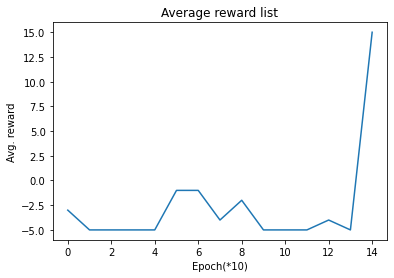

In [19]:
plt.title('Average reward list')
plt.plot(range(len(avg_rewards_list)), avg_rewards_list)
plt.xlabel('Epoch(*10)')
plt.ylabel('Avg. reward')
plt.show()

In [22]:
123

123

## Report
Due to some issues, I trained the model 4 times in total.
1. Trained 2200 epochs and got the best reward 4.0. (server disconnected)
2. Continually trained 710 epochs and got the best reward 20.0. (early stop)
3. Continually trained 280 epochs and got the best reward 36.0. (early stop)
4. Continually trained 140 epochs and got the best reward 15.0. 

Because I want to depict the reward plot, I continually trained 2 times after early stop.
Overall, I got reward bigger than 10.0 after about 3000 epochs.

I also upload the demo video to the google drive. 
Here is the link: https://drive.google.com/drive/folders/1q0C_vOqwhkJ4YLBjOBtFuOU1ScZY5dKj?usp=sharing